# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

This is a classification problem. Rather than finding a continuous solution, such as price, we are finding a discrete solution; and in this case, the classification is binary: students who either passed or failed. From there, we can use the model to predict which students will fail, so teacher can intervene.

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as pl
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn import svm
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import tree
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

In [3]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [4]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = student_data.shape[0]
n_features = student_data.shape[1] - 1
n_passed = (student_data['passed'] == 'yes').sum()
n_failed = (student_data['passed'] == 'no').sum()
grad_rate = float(n_passed) / (n_passed + n_failed) * 100
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [5]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

     ...    higher internet  romantic  famrel  freetime goout Dalc Walc  \
0    ...       yes       no        no       4         3     4    1    1   
1    ...       yes     

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [6]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)

print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [7]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=12)

print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [8]:
# Train a model
def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)
    return end - start

# TODO: Choose a model, import it and instantiate an object

clf = svm.SVC()

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
#print clf  # you can inspect the learned model by printing it

Training SVC...
Done!
Training time (secs): 0.037


0.037120819091796875

In [9]:
# Predict on training set and compute F1 score

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    f1 = f1_score(target.values, y_pred, pos_label='yes')
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1, end - start

train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score[0])

Predicting labels using SVC...
Done!
Prediction time (secs): 0.378
F1 score for training set: 0.87610619469


In [10]:
# Predict on test data
print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test)[0])

Predicting labels using SVC...
Done!
Prediction time (secs): 0.004
F1 score for test set: 0.8


In [11]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train)[0])
    print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test)[0])
    return [predict_labels(clf, X_train, y_train)[0], predict_labels(clf, X_test, y_test)[0]]

# TODO: Run the helper function above for desired subsets of training data
train_predict(clf, X_train, y_train, X_test, y_test)
# Note: Keep the test set constant

------------------------------------------
Training set size: 300
Training SVC...
Done!
Training time (secs): 0.007
Predicting labels using SVC...
Done!
Prediction time (secs): 0.006
F1 score for training set: 0.87610619469
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.8
Predicting labels using SVC...
Done!
Prediction time (secs): 0.006
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002


[0.87610619469026541, 0.80000000000000016]

In [12]:
# TODO: Train and predict using two other models
classifiers = [svm.SVC(), naive_bayes.MultinomialNB(), neighbors.KNeighborsClassifier()]

# Did one more. Was curious to know the results.
clf_two = classifiers[0]
clf_three = classifiers[1]
clf_four = classifiers[2]

second_prediction = train_predict(clf_two, X_train, y_train, X_test, y_test)
third_prediction = train_predict(clf_three, X_train, y_train, X_test, y_test)
fourth_prediction = train_predict(clf_four, X_train, y_train, X_test, y_test)

------------------------------------------
Training set size: 300
Training SVC...
Done!
Training time (secs): 0.007
Predicting labels using SVC...
Done!
Prediction time (secs): 0.006
F1 score for training set: 0.87610619469
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.8
Predicting labels using SVC...
Done!
Prediction time (secs): 0.006
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
------------------------------------------
Training set size: 300
Training MultinomialNB...
Done!
Training time (secs): 0.099
Predicting labels using MultinomialNB...
Done!
Prediction time (secs): 0.002
F1 score for training set: 0.793503480278
Predicting labels using MultinomialNB...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.794117647059
Predicting labels using MultinomialNB...
Done!
Prediction time (secs): 0.002
Predicting labels using MultinomialNB...
Done!
Prediction time (secs): 0.001
----------------------------------

## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

In [13]:
# TODO: Fine-tune your model and report the best F1 score

# Testing a range of values for each parameter, independently
# This is a manual version of Grid Search
def testing_params_C(X_train, y_train, X_test, y_test):
    # best:
    # F1 score for test set: 0.822085889571
    # C for training set: 0.4
    for i in range(1,10):
        clf = svm.SVC(C=(i*0.1))
        clf.fit(X_train, y_train)
        f1 = train_predict(clf, X_train, y_train, X_test, y_test)
        print "C for training set: {}".format(i*0.1)

def testing_params_kernel(X_train, y_train, X_test, y_test):
    clf = svm.SVC(kernel='linear')
    clf.fit(X_train, y_train)
    f1 = train_predict(clf, X_train, y_train, X_test, y_test)

def testing_params_gamma(X_train, y_train, X_test, y_test):
    # best: 
    # F1 score for test set: 0.822085889571
    # gamma = 0.1
    for i in range(1,10):
        clf = svm.SVC(gamma=i*0.1)
        clf.fit(X_train, y_train)
        train_predict(clf, X_train, y_train, X_test, y_test)
        print "Gamma = {}".format(i*0.1)

def testing_params_combine(X_train, y_train, X_test, y_test):
    # F1 for test decreases when combining
    for i in range(1,10):
        clf = svm.SVC(C=0.7, gamma=i*0.1)
        clf.fit(X_train, y_train)
        f1 = train_predict(clf, X_train, y_train, X_test, y_test)
        print "C: {}, gamma: {}".format(0.7, i*0.1)

testing_params_C(X_train, y_train, X_test, y_test)
#testing_params_kernel(X_train, y_train, X_test, y_test)
#testing_params_gamma(X_train, y_train, X_test, y_test)
#testing_params_combine(X_train, y_train, X_test, y_test)

------------------------------------------
Training set size: 300
Training SVC...
Done!
Training time (secs): 0.007
Predicting labels using SVC...
Done!
Prediction time (secs): 0.006
F1 score for training set: 0.8
Predicting labels using SVC...
Done!
Prediction time (secs): 0.003
F1 score for test set: 0.8125
Predicting labels using SVC...
Done!
Prediction time (secs): 0.006
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
C for training set: 0.1
------------------------------------------
Training set size: 300
Training SVC...
Done!
Training time (secs): 0.010
Predicting labels using SVC...
Done!
Prediction time (secs): 0.006
F1 score for training set: 0.8
Predicting labels using SVC...
Done!
Prediction time (secs): 0.003
F1 score for test set: 0.8125
Predicting labels using SVC...
Done!
Prediction time (secs): 0.006
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
C for training set: 0.2
------------------------------------------
Training set size: 

In [19]:
# Grid Search for neighbors.KNeighborsClassifier()
def find_best_neighbors(clf, X_train, y_train):
    start = time.time()
    algo = ['ball_tree', 'kd_tree', 'brute']
    weight = ['distance']
    dist_metric = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
    params = {'n_neighbors': range(3,11), 'weights': weight, 'algorithm': algo, 'metric': dist_metric}
    combinations = reduce(lambda x,y: x*y, [len(x) for x in params.values()])
    scorer = make_scorer(f1_score, pos_label='yes')
    
    grid_clf = GridSearchCV(clf, params, scoring=scorer)
    grid_clf.fit(X_train, y_train)
    end = time.time()
    
    print "Best Estimator: "
    print grid_clf.best_estimator_
    print "Best Score: {}".format(grid_clf.best_score_)
    print "Best Parameters: {}".format(grid_clf.best_params_)
    print "Best Scorer: {}".format(grid_clf.scorer_)
    print "{} seconds per algorithm for {}".format((end - start)/float(combinations), clf.__class__.__name__)
    
    
def find_best_svm(clf, X_train, y_train):
    # create Grid Search CV to find the best parameter combination
    start = time.time()
    
    param_range = [x*0.1 for x in range(1,20)]
    # the combination of parameters make this very slow: 48 seconds
    params = {'C': param_range, 'gamma': param_range, 'degree': range(2,6)}
    # the product function, equivalent to sum(some_array)
    combinations = reduce(lambda x,y: x*y, [len(x) for x in params.values()])
    scorer = make_scorer(f1_score, pos_label='yes')

    grid_clf = GridSearchCV(clf, params, scoring=scorer)
    grid_clf.fit(X_train, y_train)
    end = time.time()

    print "Best Estimator: "
    print grid_clf.best_estimator_
    print "Best F1 Score: {}".format(grid_clf.best_score_)
    print "Optimal parameters: {}".format(grid_clf.best_params_)
    print "{} seconds per algorithm for {}".format((end - start)/float(combinations), clf.__class__.__name__)
    
    
def find_best_nb(clf, X_train, y_train):
    start = time.time()
    param_range_int = range(1,20)
    param_range_percent = [x*0.1 for x in range(1,10)]
    params = {'alpha': param_range_int}
    combinations = reduce(lambda x,y: x*y, [len(x) for x in params.values()])
    scorer = make_scorer(f1_score, pos_label='yes')
    
    grid_clf = GridSearchCV(clf, params, scoring=scorer)
    grid_clf.fit(X_train, y_train)    
    end = time.time()
    
    print "Best Estimator: "
    print grid_clf.best_estimator_
    print "Best F1 Score: {}".format(grid_clf.best_score_)
    print "Optimal parameters: {}".format(grid_clf.best_params_)
    print "{} seconds per algorithm for {}".format((end - start)/float(combinations), clf.__class__.__name__)
    
print "Grid Search for {}".format(classifiers[2].__class__.__name__)
find_best_neighbors(classifiers[2], X_train, y_train)

print "Grid Search for {}".format(classifiers[1].__class__.__name__)
find_best_nb(classifiers[1], X_train, y_train)
    
# I noted this out to avoid the total ~48 second run time
#print "Grid Search for {}".format(classifiers[0].__class__.__name__)
#find_best_svm(classifiers[0], X_train, y_train)

Grid Search for KNeighborsClassifier
Best Estimator: 
KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='distance')
Best Score: 0.816001091214
Best Parameters: {'n_neighbors': 8, 'metric': 'euclidean', 'weights': 'distance', 'algorithm': 'brute'}
Best Scorer: make_scorer(f1_score, pos_label=yes)
0.0183741773168 seconds per algorithm for KNeighborsClassifier
Grid Search for MultinomialNB
Best Estimator: 
MultinomialNB(alpha=17, class_prior=None, fit_prior=True)
Best F1 Score: 0.798765333961
Optimal parameters: {'alpha': 17}
0.0130726287239 seconds per algorithm for MultinomialNB


Graph created.
running train_set_sizes(SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))
0.87610619469
0.8


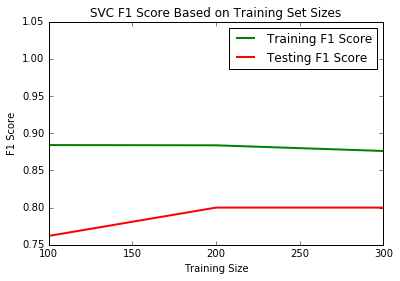

Graph created.
running train_set_sizes(MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))
0.793503480278
0.794117647059


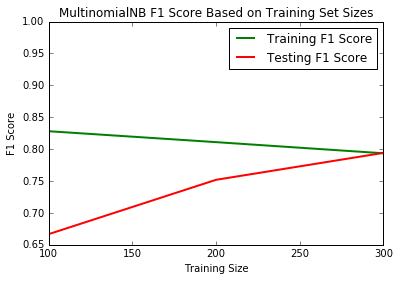

Graph created.
running train_set_sizes(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))
0.844748858447
0.808219178082


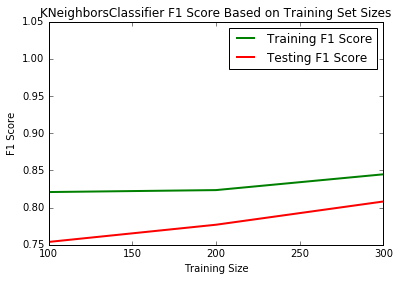

In [20]:
# graphing the training and test F1 scores, based on training size
def performance_metric(true, prediction):
    f1 = f1_score(true, prediction, pos_label='yes')
    
    return f1

def train_set_sizes(clf, X_train, y_train, X_test, y_test):
    train_sizes =[100, 200, 300]
    train_f1 = np.zeros(len(train_sizes))
    test_f1 = np.zeros(len(train_sizes))
    
    for i, s in enumerate(train_sizes):
        clf.fit(X_train[:s], y_train[:s])
        train_f1[i] = performance_metric(y_train[:s], clf.predict(X_train[:s]))
        test_f1[i] = performance_metric(y_test, clf.predict(X_test))
        
    print "Graph created."
    print "running train_set_sizes({})".format(clf)
    
    print train_f1[i]
    print test_f1[i]    
    train_sizes_graph(clf, train_sizes, train_f1, test_f1)


def train_sizes_graph(clf, training_sizes, train_f1, test_f1):
    pl.figure()
    pl.title('{} F1 Score Based on Training Set Sizes'.format(clf.__class__.__name__))
    
    pl.plot(300, 1)
    pl.plot(training_sizes, train_f1, lw=2, label='Training F1 Score')
    pl.plot(training_sizes, test_f1, lw=2, label='Testing F1 Score')
    
    pl.legend()
    pl.xlabel('Training Size')
    pl.ylabel('F1 Score')
    
    pl.show()
    
for clf in classifiers:
    train_set_sizes(clf, X_train, y_train, X_test, y_test)

In [15]:
# creates graphs from the supporting functions, above
# also creates a results table for the classifier
def run_model(clf, X_train, y_train, X_test, y_test):
    start = time.time()
    train_sizes = [100, 200, 300]
    table_data = []
    for train_size in train_sizes:
        # fit classifier
        training_time = train_classifier(clf, X_train[:train_size], y_train[:train_size])
        # predict and run the time
        prediction_time = predict_labels(clf, X_train[:train_size], y_train[:train_size])[1]
        # train and get f1 scores
        training_f1 = train_predict(clf, X_train[:train_size], y_train[:train_size], X_test, y_test)[0]
        # test and get f1 scores
        test_f1 = train_predict(clf, X_train[:train_size], y_train[:train_size], X_test, y_test)[1]
        
        table_data.append([training_time, prediction_time, training_f1, test_f1])
        
    train_set_sizes(clf, X_train[:train_size], y_train[:train_size], X_test, y_test)
    end = time.time()
    
    rows = ['Training Sizes', 'Training Time (secs)', 'Prediction Time (secs)', 'F1 score for training set', 'F1 score for test set']
    d = {'Training Sizes': rows[1:],
         '100': pd.Series(table_data[0]), 
         '200': pd.Series(table_data[1]), 
         '300': pd.Series(table_data[2])}
    table_dataframe = pd.DataFrame(d)
    
    print "Table for {} classifier".format(clf.__class__.__name__)    
    print table_dataframe
    print "{} seconds".format(end - start)
    
for clf in classifiers:
    run_model(clf, X_train, y_train, X_test, y_test)

Training SVC...
Done!
Training time (secs): 0.002
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
------------------------------------------
Training set size: 100
Training SVC...
Done!
Training time (secs): 0.002
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for training set: 0.884057971014
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.761904761905
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
------------------------------------------
Training set size: 100
Training SVC...
Done!
Training time (secs): 0.001
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for training set: 0.884057971014
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.761904761905
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
Predicting labels usin

In [17]:
# optimized F1 score

def optimized_model(X_train, y_train, X_test, y_test):
    # {'n_neighbors': 8, 'metric': 'euclidean', 'weights': 'distance', 'algorithm': 'brute'}
    
    clf = neighbors.KNeighborsClassifier(n_neighbors=8, metric='euclidean', weights='distance', algorithm='brute')
    clf.fit(X_train, y_train)
    
    print performance_metric(y_test, clf.predict(X_test))
    
print "Optimized Model's F1 Score: "
optimized_model(X_train, y_train, X_test, y_test)

Optimized Model's F1 Score: 
0.802721088435
